We analyze the time evolution of bead size during gel equilibration. We identify completed runs and test methods for simplifying the polymer network graph (linearization and removal of dangling ends). We compare various point cloud volume estimation techniques and conclude that the mean radius method is the most robust. Finally, we use this optimal method to visualize the size changes across different force fields and seeds.

In [1]:
import sys

sys.path.append("../")

In [2]:
import time
import tqdm
from pathlib import Path

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import analysis.form
from analysis.distribution import rnd_from_file
from utils.mymath import online_mean_and_ci


/Users/r/Documents/work/icp/microgel/code


In [3]:
def collect_directory_data(directories: list[Path]) -> pd.DataFrame:
    """
    Collects data about directories, including the most recently updated file
    and its timestamp.

    Args:
        directories: A list of directory paths.

    Returns:
        A pandas DataFrame containing directory information or None if an error occurs.
    """

    data = []
    for dir_path in directories:
        try:
            # Check if directory exists
            if not dir_path.is_dir():
                print(
                    f"Warning: Directory not found: {dir_path}"
                )  # Or raise an exception
                continue  # Skip to the next directory

            most_recent_file = None
            most_recent_timestamp = 0

            for file_path in dir_path.rglob("*"):
                if not file_path.is_file():
                    continue
                if file_path.name in [
                    "main.log",
                    "config.json",
                    "current_checkpoint.txt",
                    "p3m_params.json",
                ]:
                    continue
                timestamp = file_path.stat().st_mtime
                if timestamp > most_recent_timestamp:
                    most_recent_timestamp = timestamp
                    most_recent_file = file_path

            # Store data, even if no files were found in the directory
            data.append(
                {
                    "Directory": dir_path,
                    "MostRecentFile": most_recent_file,
                    "Timestamp": most_recent_timestamp,
                }
            )

        except Exception as e:  # Handle potential errors (permissions, etc.)
            print(f"Error processing directory {dir_path}: {e}")
            return pd.DataFrame.from_records(
                [], columns=["Directory", "MostRecentFile", "Timestamp"]
            )

    df = pd.DataFrame(data)
    df["Timestamp"] = pd.to_datetime(df["Timestamp"], unit="s")

    return df


# Example usage:
root = Path("../../data/raw/30112024_forcefield_eq_time_fixed")
directories_to_check = list(root.iterdir())
df = collect_directory_data(directories_to_check).sort_values(
    "Timestamp", ignore_index=True
)
display(df[~df["MostRecentFile"].isna()])
for p in df.loc[~df["MostRecentFile"].isna(), "Directory"].iloc[-4:].tolist():
    print(f"{p.resolve()}")

,Directory,MostRecentFile,Timestamp
11,../../data/raw/30112024_forcefield_eq_time_fix...,../../data/raw/30112024_forcefield_eq_time_fix...,2024-11-30 02:24:15.736558080
12,../../data/raw/30112024_forcefield_eq_time_fix...,../../data/raw/30112024_forcefield_eq_time_fix...,2024-11-30 02:24:15.873523456
13,../../data/raw/30112024_forcefield_eq_time_fix...,../../data/raw/30112024_forcefield_eq_time_fix...,2024-11-30 02:24:16.342073088
14,../../data/raw/30112024_forcefield_eq_time_fix...,../../data/raw/30112024_forcefield_eq_time_fix...,2024-11-30 02:24:16.498845952
15,../../data/raw/30112024_forcefield_eq_time_fix...,../../data/raw/30112024_forcefield_eq_time_fix...,2024-11-30 02:24:16.676485632
...,...,...,...
265,../../data/raw/30112024_forcefield_eq_time_fix...,../../data/raw/30112024_forcefield_eq_time_fix...,2024-12-04 12:27:29.103320832
266,../../data/raw/30112024_forcefield_eq_time_fix...,../../data/raw/30112024_forcefield_eq_time_fix...,2024-12-04 13:51:23.034243840
267,../../data/raw/30112024_forcefield_eq_time_fix...,../../data/raw/30112024_forcefield_eq_time_fix...,2024-12-04 13:54:29.225589248
268,../../data/raw/30112024_forcefield_eq_time_fix...,../../data/raw/30112024_forcefield_eq_time_fix...,2024-12-04 13:54:57.649385728


/Users/r/Documents/work/icp/microgel/code/data/raw/30112024_forcefield_eq_time_fixed/run=1_ff=exp_charge=0.15_vf=0.3_crosslink=0.7
/Users/r/Documents/work/icp/microgel/code/data/raw/30112024_forcefield_eq_time_fixed/run=1_ff=exp_charge=0.15_vf=0.45_crosslink=0.2
/Users/r/Documents/work/icp/microgel/code/data/raw/30112024_forcefield_eq_time_fixed/run=1_ff=none_charge=0.15_vf=0.45_crosslink=0.2
/Users/r/Documents/work/icp/microgel/code/data/raw/30112024_forcefield_eq_time_fixed/run=1_ff=harmonic_charge=0.15_vf=0.45_crosslink=0.2


In [4]:
df["MostRecentFile"].iloc[-10:].tolist()

[PosixPath('../../data/raw/30112024_forcefield_eq_time_fixed/run=0_ff=exp_charge=0.15_vf=0.6_crosslink=0.7/checkpoints/GelEqDone/active_agents.npy'),
 PosixPath('../../data/raw/30112024_forcefield_eq_time_fixed/run=1_ff=none_charge=0.15_vf=0.3_crosslink=0.2/checkpoints/GelEqDone/active_agents.npy'),
 PosixPath('../../data/raw/30112024_forcefield_eq_time_fixed/run=1_ff=harmonic_charge=0.15_vf=0.3_crosslink=0.2/checkpoints/GelEqDone/active_agents.npy'),
 PosixPath('../../data/raw/30112024_forcefield_eq_time_fixed/run=1_ff=exp_charge=0.15_vf=0.3_crosslink=0.2/checkpoints/GelEqDone/active_agents.npy'),
 PosixPath('../../data/raw/30112024_forcefield_eq_time_fixed/run=1_ff=none_charge=0.15_vf=0.3_crosslink=0.7/checkpoints/GelEqDone/active_agents.npy'),
 PosixPath('../../data/raw/30112024_forcefield_eq_time_fixed/run=1_ff=harmonic_charge=0.15_vf=0.3_crosslink=0.7/checkpoints/GelEqDone/active_agents.npy'),
 PosixPath('../../data/raw/30112024_forcefield_eq_time_fixed/run=1_ff=exp_charge=0.15_vf

In [5]:
finished_gel_dirs = []
for gel_dir_path in directories_to_check:
    if (gel_dir_path / "checkpoints/GelEqDone").exists():
        finished_gel_dirs.append(gel_dir_path.resolve())
        print(gel_dir_path.relative_to(root), "is done")
print(f"{len(finished_gel_dirs)}/{len(directories_to_check)} done")

with open("../../finished_gel_dirs.txt", "w", encoding="utf-8") as f:
    f.writelines(map(lambda p: str(p) + "\n", finished_gel_dirs))

run=3_ff=exp_charge=0.05_vf=0.45_crosslink=0.7 is done
run=0_ff=harmonic_charge=0.15_vf=0.45_crosslink=0.7 is done
run=3_ff=exp_charge=0.05_vf=0.6_crosslink=0.2 is done
run=3_ff=none_charge=0.05_vf=0.3_crosslink=0.2 is done
run=4_ff=none_charge=0.05_vf=0.6_crosslink=0.7 is done
run=0_ff=exp_charge=0.15_vf=0.45_crosslink=0.7 is done
run=0_ff=none_charge=0.05_vf=0.6_crosslink=0.7 is done
run=4_ff=harmonic_charge=0.05_vf=0.3_crosslink=0.7 is done
run=2_ff=exp_charge=0.05_vf=0.6_crosslink=0.2 is done
run=0_ff=none_charge=0.15_vf=0.6_crosslink=0.2 is done
run=3_ff=harmonic_charge=0.05_vf=0.45_crosslink=0.7 is done
run=2_ff=none_charge=0.05_vf=0.3_crosslink=0.7 is done
run=0_ff=exp_charge=0.15_vf=0.6_crosslink=0.7 is done
run=2_ff=exp_charge=0.05_vf=0.45_crosslink=0.2 is done
run=2_ff=harmonic_charge=0.05_vf=0.3_crosslink=0.2 is done
run=3_ff=harmonic_charge=0.05_vf=0.6_crosslink=0.2 is done
run=4_ff=exp_charge=0.05_vf=0.3_crosslink=0.7 is done
run=0_ff=exp_charge=0.05_vf=0.6_crosslink=0.2 i

In [10]:
import common

bead_dfs = []
for gel_dir in map(common.GelDir, root.iterdir()):
    bead_df = gel_dir.beads_gel_eq()
    if bead_df.empty:
        continue
    for k, v in dict(s.split("=") for s in gel_dir.path.name.split("_")).items():
        bead_df[k] = v
    bead_df["seed"] = gel_dir.config.seed
    bead_dfs.append(bead_df)

bead_df = pd.concat(bead_dfs, ignore_index=True)
bead_df[["run", "seed"]] = bead_df[["run", "seed"]].astype(int)
bead_df[["ff"]] = bead_df[["ff"]].astype("category")
bead_df[["charge", "vf", "crosslink"]] = bead_df[["charge", "vf", "crosslink"]].astype(
    float
)
bead_df

,path,timestep,run,ff,charge,vf,crosslink,seed
0,../../data/raw/30112024_forcefield_eq_time_fix...,5000,3,exp,0.05,0.45,0.7,95399302
1,../../data/raw/30112024_forcefield_eq_time_fix...,10000,3,exp,0.05,0.45,0.7,95399302
2,../../data/raw/30112024_forcefield_eq_time_fix...,15000,3,exp,0.05,0.45,0.7,95399302
3,../../data/raw/30112024_forcefield_eq_time_fix...,20000,3,exp,0.05,0.45,0.7,95399302
4,../../data/raw/30112024_forcefield_eq_time_fix...,25000,3,exp,0.05,0.45,0.7,95399302
...,...,...,...,...,...,...,...,...
2270,../../data/raw/30112024_forcefield_eq_time_fix...,80000,0,none,0.15,0.30,0.2,66984208
2271,../../data/raw/30112024_forcefield_eq_time_fix...,85000,0,none,0.15,0.30,0.2,66984208
2272,../../data/raw/30112024_forcefield_eq_time_fix...,90000,0,none,0.15,0.30,0.2,66984208
2273,../../data/raw/30112024_forcefield_eq_time_fix...,95000,0,none,0.15,0.30,0.2,66984208


In [12]:
import analysis.network
import analysis.form

from typing import Any
import networkx as nx


def _can_node_be_removed(G: nx.Graph, node) -> tuple[bool, Any]:
    if G.degree[node] != 2:  # type: ignore
        return False, None

    neighbors = tuple(G.neighbors(node))
    for neighbor_node in neighbors:
        # if one neighbor has degree < 3, it can be merged with that neighbor
        if G.degree[neighbor_node] < 3:  # type: ignore
            if neighbors not in G.edges:
                return True, neighbor_node
    else:
        # if not, it can still be merged, if the edge resulting from that not already exists
        assert len(neighbors) == 2, len(neighbors)
        if neighbors not in G.edges:
            return True, neighbor_node

    return False, None


def linearize_graph(G: nx.Graph):
    G2 = G.copy()

    nodes_to_remove = list(G2.nodes)
    n_removed = 0
    while len(nodes_to_remove) > 0:
        node = nodes_to_remove.pop()
        can_remove, neighbor = _can_node_be_removed(G2, node)
        if can_remove:
            G2 = nx.contracted_nodes(G2, neighbor, node, self_loops=False)
            n_removed += 1

    if n_removed > 0:
        G2 = linearize_graph(G2)

    return G2


single_bead_df = bead_df[bead_df["seed"] == 95399302]

gel_proxy = analysis.GelProxy.from_gel_dir(
    single_bead_df.path.iloc[0].parent.parent.parent
)
print("Creating Graph")
G = analysis.network.graph_from_gel_proxy(gel_proxy)
print("Linearizing Graph")
G_linear = linearize_graph(G)
print(G.number_of_nodes())
print(G_linear.number_of_nodes())
print(single_bead_df["path"])

Creating Graph
Linearizing Graph
4200
2933
0     ../../data/raw/30112024_forcefield_eq_time_fix...
1     ../../data/raw/30112024_forcefield_eq_time_fix...
2     ../../data/raw/30112024_forcefield_eq_time_fix...
3     ../../data/raw/30112024_forcefield_eq_time_fix...
4     ../../data/raw/30112024_forcefield_eq_time_fix...
5     ../../data/raw/30112024_forcefield_eq_time_fix...
6     ../../data/raw/30112024_forcefield_eq_time_fix...
7     ../../data/raw/30112024_forcefield_eq_time_fix...
8     ../../data/raw/30112024_forcefield_eq_time_fix...
9     ../../data/raw/30112024_forcefield_eq_time_fix...
10    ../../data/raw/30112024_forcefield_eq_time_fix...
11    ../../data/raw/30112024_forcefield_eq_time_fix...
12    ../../data/raw/30112024_forcefield_eq_time_fix...
13    ../../data/raw/30112024_forcefield_eq_time_fix...
14    ../../data/raw/30112024_forcefield_eq_time_fix...
15    ../../data/raw/30112024_forcefield_eq_time_fix...
16    ../../data/raw/30112024_forcefield_eq_time_fix...
17   

In [13]:
single_bead_df["path"].iloc[0].parent.parent.parent.resolve()

PosixPath('/Users/r/Documents/work/icp/microgel/code/data/raw/30112024_forcefield_eq_time_fixed/run=3_ff=exp_charge=0.05_vf=0.45_crosslink=0.7')

In [14]:
def remove_dangling_ends(G: nx.Graph):
    G2 = G.copy()

    for node in G.nodes:
        if G2.degree[node] == 1:
            G2.remove_node(node)
            break
    else:
        return G2

    return remove_dangling_ends(G2)
    
G_linear_no_dangling = remove_dangling_ends(G_linear)
print(G_linear.number_of_nodes())
print(G_linear_no_dangling.number_of_nodes())

2933
2896


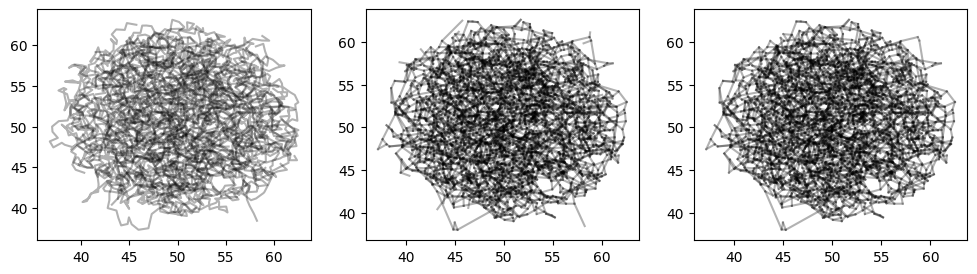

In [15]:
bead_points = np.load(single_bead_df["path"].iloc[-1])
chains = np.split(bead_points, gel_dir.config.n_chains)

fig, axs = plt.subplots(ncols=3, figsize=(12, 3))

for chain in chains:
    axs[0].plot(*chain[:, :2].T, "k-", alpha=0.3)

for n1, n2 in G_linear.edges:
    p1 = bead_points[n1, :2]
    p2 = bead_points[n2, :2]
    axs[1].plot(*np.array([p1, p2]).T, "k-", alpha=0.3)

for n1, n2 in G_linear_no_dangling.edges:
    p1 = bead_points[n1, :2]
    p2 = bead_points[n2, :2]
    axs[2].plot(*np.array([p1, p2]).T, "k-", alpha=0.3)

In [16]:
import importlib

from analysis import hyperplane_volume

importlib.reload(hyperplane_volume)

<module 'analysis.hyperplane_volume' from '/Users/r/Documents/work/icp/microgel/code/src/notebooks/../analysis/hyperplane_volume.py'>

                     bounding_box_volume: 1.7e-02
                      convex_hull_volume: 3.7e-02
                       pca_extent_volume: 2.0e-02
                  mean_pairwise_distance: 5.2e-01
                      radius_of_gyration: 7.9e-03
                   max_pairwise_distance: 5.0e-01
                              radius_max: 8.1e-03
                             radius_mean: 8.0e-03
                           radius_median: 1.0e-02
                            hydro_radius: 7.4e-01
                               dens_hist: 2.3e-02
                             hyperplanes: 3.1e-01


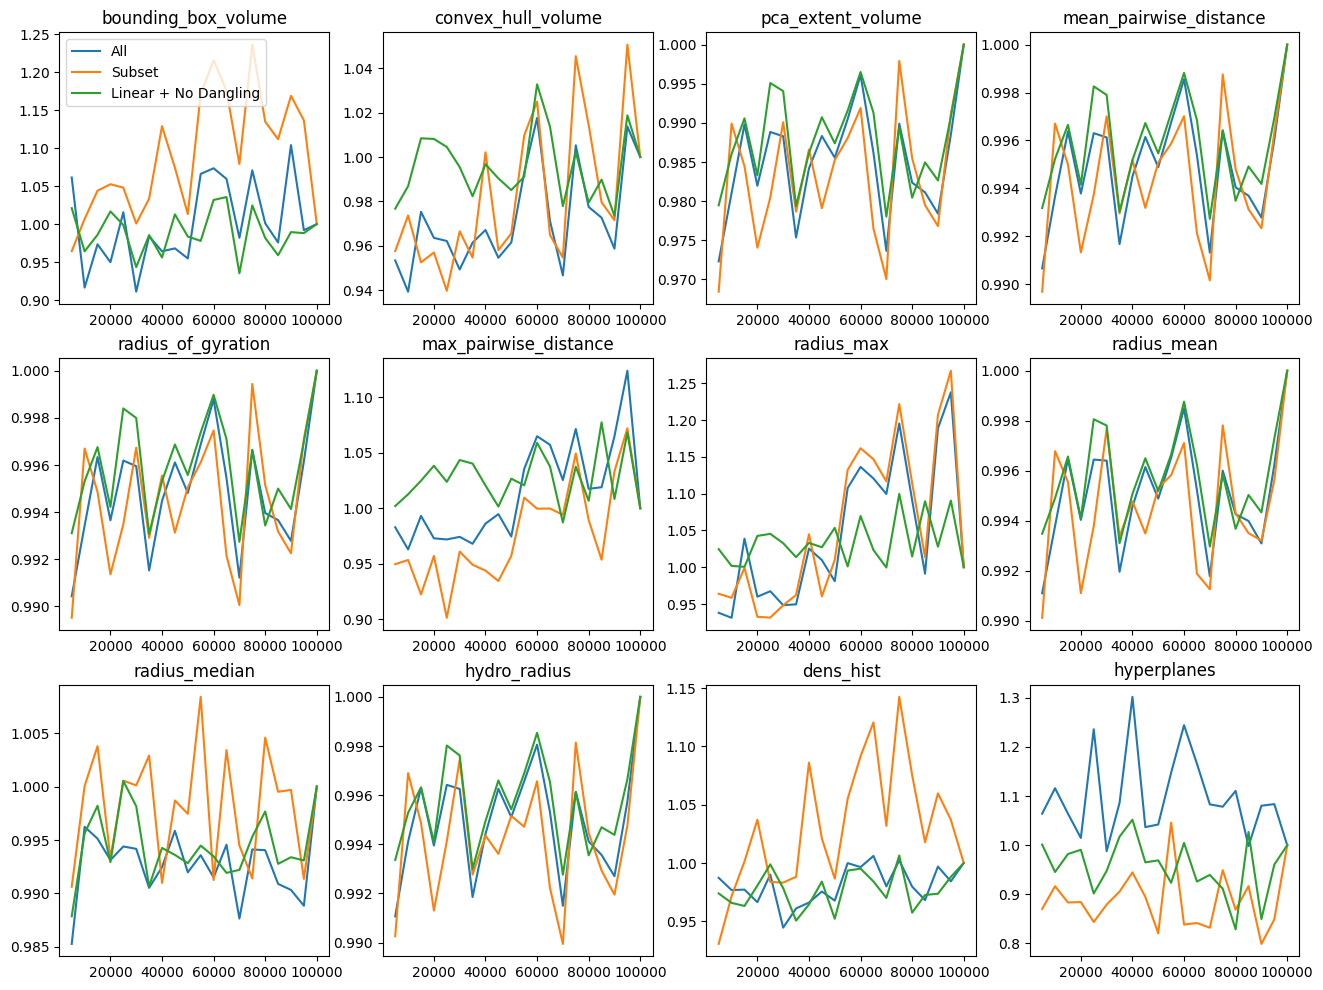

In [17]:
from scipy.spatial.distance import pdist

def hydro_radius(points):
    N = len(points)
    distances = pdist(points)
    rh_inv = float(np.sum(1.0 / distances))
    rh_inv *= 2.0 / (N * (N - 1))
    return 1.0 / rh_inv

def density_histogram(points, resolution=10, density_threshold=1.6*1e-5):
    dens, bin_edges = np.histogramdd(points, bins=resolution, density=True)
    n_cells = np.count_nonzero(dens >= density_threshold)

    cell_size = [bin_edges[dim][1] - bin_edges[dim][0] for dim in range(points.shape[1])]
    cell_volume = np.prod(cell_size)
    volume = n_cells * cell_volume

    return volume

methods = [
    (s, getattr(analysis.form.PointCloudVolume, s))
    for s in [
        "bounding_box_volume",
        "convex_hull_volume",
        "pca_extent_volume",
        "mean_pairwise_distance",
        "radius_of_gyration",
        # "hydrodynamic_radius",
        "max_pairwise_distance",
    ]
]
methods.extend(
    [
        (
            "radius_max",
            lambda points: analysis.form.PointCloudVolume.radius(points, method="max"),
        ),
        (
            "radius_mean",
            lambda points: analysis.form.PointCloudVolume.radius(
                points, method="average"
            ),
        ),
        (
            "radius_median",
            lambda points: analysis.form.PointCloudVolume.radius(
                points, method="median"
            ),
        ),
        (
            "hydro_radius", hydro_radius,
        ),
        (
            "dens_hist", density_histogram,
        ),
        (
            "hyperplanes", lambda points: hyperplane_volume.estimate_volume_hyperplanes(points, p=10),
        ),
    ]
)

import time

fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(16, 12))
axs = axs.flat
for name, method in methods:
    ax: plt.Axes = next(axs)
    ts = []
    sizes1 = []
    sizes2 = []
    sizes3 = []
    dt = time.time()
    for i, row in single_bead_df.iloc[::1].iterrows():
        points = np.load(row["path"])
        points_subset = points[::10]
        size1 = method(points)
        size2 = method(points_subset)
        size3 = method(points[G_linear_no_dangling.nodes])

        ts.append(row["timestep"])
        sizes1.append(size1)
        sizes2.append(size2)
        sizes3.append(size3)
    dt = time.time() - dt
    print(f"{name:>40}: {dt:.1e}")
    sizes1 = np.array(sizes1) / sizes1[-1]
    sizes2 = np.array(sizes2) / sizes2[-1]
    sizes3 = np.array(sizes3) / sizes3[-1]
    ax.set_title(name)
    ax.plot(ts, sizes1, "-", label="All")
    ax.plot(ts, sizes2, "-", label="Subset")
    ax.plot(ts, sizes3, "-", label="Linear + No Dangling")
axs[0].legend()
plt.show()

# conclusion: Radius mean is best

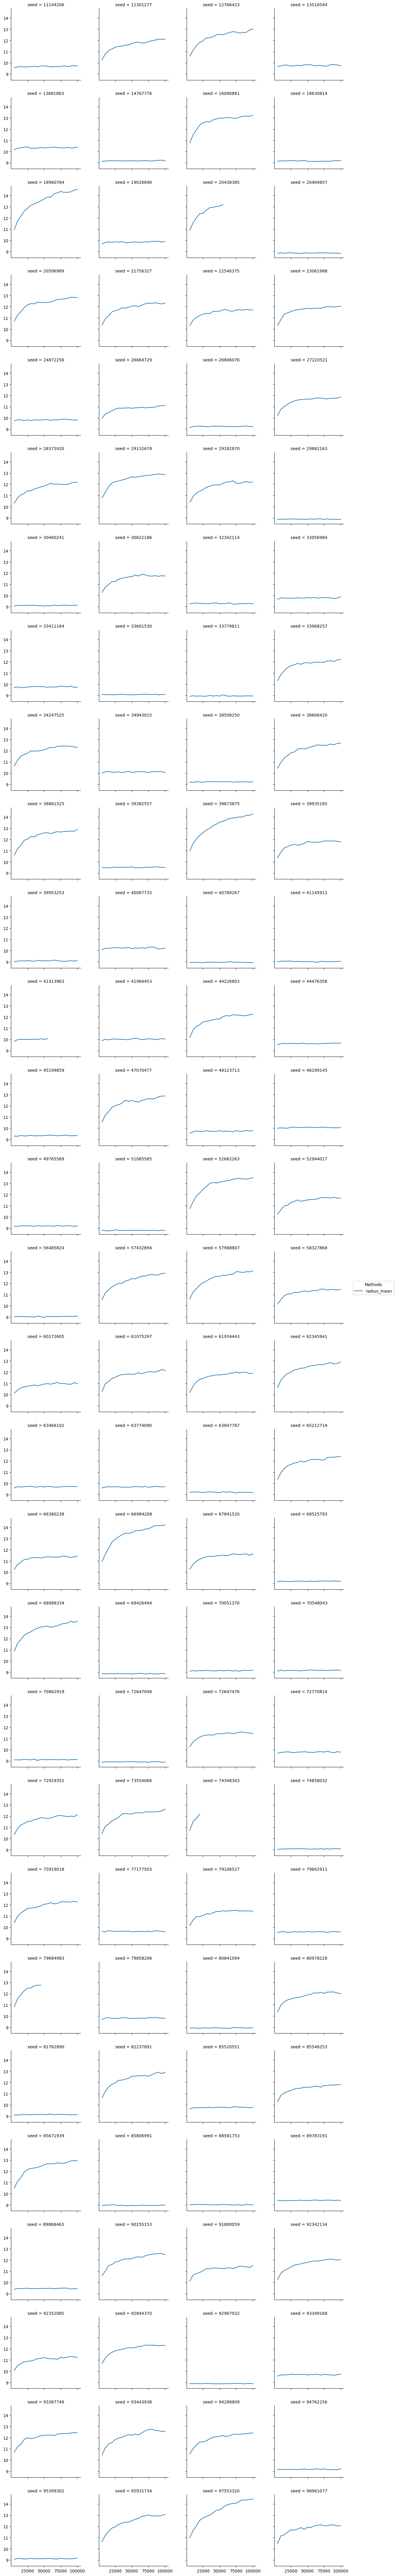

,timestep,size,method,seed
0,5000,9.538329,radius_mean,11144206
1,10000,9.629953,radius_mean,11144206
2,15000,9.659120,radius_mean,11144206
3,20000,9.626158,radius_mean,11144206
4,25000,9.629638,radius_mean,11144206
...,...,...,...,...
2270,80000,12.048198,radius_mean,98961077
2271,85000,12.139117,radius_mean,98961077
2272,90000,12.115185,radius_mean,98961077
2273,95000,12.039042,radius_mean,98961077


In [28]:
g = sns.FacetGrid(bead_df, hue="ff", col="seed", col_wrap=4, sharey=True)

methods = [
    (s, getattr(analysis.form.PointCloudVolume, s))
    for s in [
        # "bounding_box_volume",
        # "convex_hull_volume",
        # "pca_extent_volume",
        # "mean_pairwise_distance",
        # "radius_of_gyration",
        # "hydrodynamic_radius",
        # "max_pairwise_distance",
    ]
]
methods.extend(
    [
        # ("radius_max", lambda points: analysis.form.PointCloudVolume.radius(points, method="max")),
        (
            "radius_mean",
            lambda points: analysis.form.PointCloudVolume.radius(
                points, method="average"
            ),
        ),
        # (
        #     "hyperplane",
        #     hyperplane_volume.estimate_volume_hyperplanes,
        # ),
        # very unstable compared to radius_mean
    ]
)

# Collect legend handles and labels for each method
legend_handles = []
legend_labels = []

size_records = []

for (seed, ff), sub_df in bead_df.groupby(["seed", "ff"]):
    ax: plt.Axes = g.axes_dict[seed]
    for name, method in methods:
        x = []
        y = []
        for t, p in sub_df[["timestep", "path"]].iloc[:20].to_numpy():
            points = np.load(p)[::10]
            size = method(points)
            x.append(t)
            y.append(size)
            size_records.append(dict(timestep=t, size=size, method=name, seed=seed))
        x = np.array(x)
        y = np.array(y)
        # y /= y[-1]

        # Plot and collect the line handle
        (line,) = ax.plot(x, y, label=name)

        # Only add the handle and label once for each method
        if name not in legend_labels:
            legend_handles.append(line)
            legend_labels.append(name)

size_df = pd.DataFrame.from_records(size_records)

# Create an external legend with collected handles and labels
g.figure.legend(
    handles=legend_handles,
    labels=legend_labels,
    title="Methods",
    bbox_to_anchor=(1.0, 0.5),
    loc="center left",
    borderaxespad=0.0,
)

plt.show()
size_df
